In [1]:
# Import all the necessary libraries
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import requests
import os
import pandas as pd
import numpy as np
import warnings

# Do not print warnings
warnings.filterwarnings('ignore')

# 1. site effects dataset

In [2]:
df1 = pd.read_csv('site-effects.txt', sep='\s+', error_bad_lines=False, index_col=False, dtype='unicode')
df1

,HugoSymbol,Location,Action,Status
0,BCR/ABL fusion,Y177,PHOSPHORYLATION,1
1,AANAT,T31,PHOSPHORYLATION,0
2,AATF,S143,PHOSPHORYLATION,1
3,AATF,S189,PHOSPHORYLATION,1
4,AATF,S477,PHOSPHORYLATION,1
...,...,...,...,...
10585,ZRANB1,T35,PHOSPHORYLATION,1
10586,ZWINT,S250,PHOSPHORYLATION,0
10587,ZWINT,S262,PHOSPHORYLATION,0
10588,ZWINT,T251,PHOSPHORYLATION,0


In [3]:
df1['Action'].value_counts()

PHOSPHORYLATION    9682
ACETYLATION         648
METHYLATION         148
UBIQUITINATION      112
Name: Action, dtype: int64

# 2. OncoKB Cancer Gene List

In [4]:
df2 = pd.read_csv('OncoKB-CancerGeneList.tsv', sep='\s+', error_bad_lines=False, index_col=False, dtype='unicode')
df2

,HugoSymbol,EntrezGeneID,Isoform,RefSeq,#ofOccurrenceWithinResources(Column-D-J),OncoKBAnnotated,IsOncogene,IsTumorSuppressorGene,MSK-IMPACT,MSK-HEME,FOUNDATIONONE,FOUNDATION-ONE-HEME,Vogelstein,SANGERCGC(05/30/2017)
0,LYL1,4066,2,No,No,No,No,No,No,Yes,No,Yes,NaN,NaN
1,LYN,4067,ENST00000519728,NM_002350.3,4,Yes,Yes,No,Yes,Yes,Yes,No,No,No
2,SH2D1A,4068,ENST00000371139,NM_002351.4,3,Yes,No,Yes,Yes,Yes,No,No,No,No
3,OLIG2,10215,1,No,No,No,No,No,No,No,No,Yes,NaN,NaN
4,EPCAM,4072,ENST00000263735,NM_002354.2,3,Yes,No,Yes,Yes,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,GREM1,26585,ENST00000300177,NM_013372.6,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1055,EGFL7,51162,ENST00000308874,NM_201446.2,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1056,LTK,4058,1,No,No,No,No,No,Yes,No,No,No,NaN,NaN
1057,SPRTN,83932,ENST00000295050,NM_032018.6,2,Yes,No,Yes,Yes,No,No,No,No,No


#### Removind unnecessary columns except IsOncogene and IsTumorSupressorGene

In [5]:
df2 = df2[['HugoSymbol', 'IsOncogene', 'IsTumorSuppressorGene']]
df2

,HugoSymbol,IsOncogene,IsTumorSuppressorGene
0,LYL1,No,No
1,LYN,Yes,No
2,SH2D1A,No,Yes
3,OLIG2,No,No
4,EPCAM,No,Yes
...,...,...,...
1054,GREM1,Yes,No
1055,EGFL7,Yes,No
1056,LTK,No,No
1057,SPRTN,No,Yes


In [6]:
# Export to csv
df2.to_csv('data/OncoKBCancerGeneList.csv', index=False)

#### Print counts of IsOncogene and IsTumorSupressorGene

No     769
Yes    290
Name: IsOncogene, dtype: int64


<AxesSubplot:>

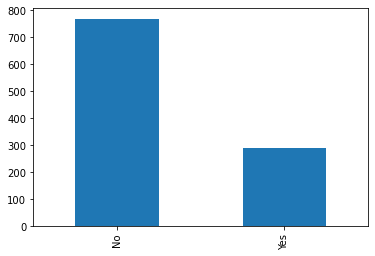

In [7]:
print(df2['IsOncogene'].value_counts())
pd.value_counts(df2['IsOncogene']).plot.bar()

No     758
Yes    301
Name: IsTumorSuppressorGene, dtype: int64


<AxesSubplot:>

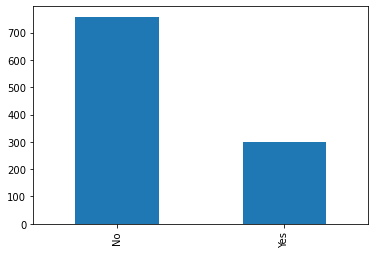

In [8]:
print(df2['IsTumorSuppressorGene'].value_counts())
pd.value_counts(df2['IsTumorSuppressorGene']).plot.bar()

In [9]:
# Genes which are behaving as both tumor supressor and oncogene
both = df2[df2['IsOncogene'] == 'Yes']
both = both[both['IsTumorSuppressorGene'] == 'Yes']

both.shape

(39, 3)

In [10]:
# Genes which are behaving as both tumor supressor and oncogene
bothNot = df2[df2['IsOncogene'] == 'No']
bothNot = bothNot[bothNot['IsTumorSuppressorGene'] == 'No']

bothNot

,HugoSymbol,IsOncogene,IsTumorSuppressorGene
0,LYL1,No,No
3,OLIG2,No,No
5,LEF1,No,No
6,RPL5,No,No
9,HIST2H3C,No,No
...,...,...,...
1051,TAF15,No,No
1052,ELK4,No,No
1053,ELN,No,No
1056,LTK,No,No


#### Plotting values for better insights

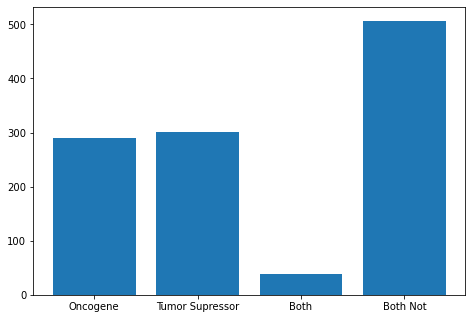

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Oncogene', 'Tumor Supressor', 'Both', 'Both Not']
values = [df2['IsOncogene'].value_counts()[1], df2['IsTumorSuppressorGene'].value_counts()[1], both.shape[0], bothNot.shape[0]]
ax.bar(langs, values)
plt.show()

# 3. Causal priors dataset

In [12]:
fields = ['Gene', 'Action', 'Output']
df3 = pd.read_csv('causal-priors.txt', sep='\s+', error_bad_lines=False, index_col=False, dtype='unicode', skipinitialspace=True, usecols=fields)
df3

,Gene,Action,Output
0,AKR1C4,produces,CHEBI:18011
1,SULT1A1,consumes,CHEBI:207496
2,INS,phosphorylates,IRS2
3,INS,phosphorylates,IRS4
4,MAK,upregulates-expression,KLK3
...,...,...,...
104248,BAMBI,dephosphorylates,TGFBR3
104249,BAMBI,dephosphorylates,TGFBR1
104250,AFMID,consumes,CHEBI:36407
104251,ARNT,upregulates-expression,FLT1


#### Removing small chemical compunds CHEBI

In [13]:
newdf3 = df3[~df3["Output"].str.contains("CHEBI")]
newdf3

,Gene,Action,Output
2,INS,phosphorylates,IRS2
3,INS,phosphorylates,IRS4
4,MAK,upregulates-expression,KLK3
5,HDAC4,deacetylates,YWHAE
6,INS,phosphorylates,IRS1
...,...,...,...
104244,LEF1,upregulates-expression,MMP2
104248,BAMBI,dephosphorylates,TGFBR3
104249,BAMBI,dephosphorylates,TGFBR1
104251,ARNT,upregulates-expression,FLT1


In [14]:
newdf3['Action'].value_counts()

phosphorylates              25549
upregulates-expression       8942
dephosphorylates             4648
downregulates-expression     2897
deacetylates                 1210
acetylates                   1020
methylates                    714
demethylates                  329
activates-gtpase              210
inhibits-gtpase                62
Name: Action, dtype: int64